In [ ]:
%matplotlib inline

import collections
from IPython.display import SVG

import numpy as np
import matplotlib.pyplot as plt

import tsinfer
from test_mutation_rates import setup_simulation, simulate_human

In [2]:
ts, prefix = simulate_human(123, each_pop_n=20)


In [3]:
err_samples, rho, prefix, ts = setup_simulation(ts, prefix, err=0.01)
err_samples = err_samples.copy()
err_samples.sites_inference[:] = np.logical_and(
    err_samples.sites_inference[:],
    # also exclude n-1 tons, which are usually singletons which have switched
    np.sum(err_samples.sites_genotypes[:]==1, axis=1) != err_samples.num_samples-1)
err_samples.finalise()

/usr/local/lib/python3.7/site-packages/zarr/storage.py:393: FutureWarning: missing object_codec for object array; this will raise a ValueError in version 3.0
  'ValueError in version 3.0', FutureWarning)


In [4]:
best_samples, _, _, _ = setup_simulation(ts, prefix, err=0)

In [6]:
site_positions = ts.tables.sites.position[:]
active_nodes = set()
saved_mutations = {}
active_mutations = {}
curr_site=0
for interval, e_out, e_in in ts.edge_diffs():
    for e in e_out:
        active_nodes.discard(e.parent)
        active_nodes.discard(e.child)
    for e in e_in:
        active_nodes.add(e.parent)
        active_nodes.add(e.child)
    new_mutations = set()
    while curr_site<len(site_positions) and site_positions[curr_site] < interval[1]:
        for m in ts.site(curr_site).mutations:
            new_mutations.add(m.id)
        curr_site += 1
    for m_id in list(active_mutations.keys()):
        if active_mutations[m_id][2] not in active_nodes:
            saved_mutations[m_id] = active_mutations.pop(m_id)
        else:
            active_mutations[m_id][1] = interval[1]
    for m_id in new_mutations:
        active_mutations[m_id] = [interval[0], interval[1], ts.mutation(m_id).node]
saved_mutations.update(active_mutations)

In [7]:
samples = err_samples

In [8]:
anc = tsinfer.generate_ancestors(samples)

In [9]:
anc.ancestors_focal_sites[:].shape, np.sum(samples.sites_inference[:]), samples.num_sites

((11133,), 14481, 22514)

In [10]:
# Map ancestors onto their correct edges
inference_map = np.arange(samples.num_sites)[samples.sites_inference[:]]
inference_map = np.append(inference_map, -1)  # Map off-the-end to the last value


freq = []
overlap = []
excess = []
site = []
mutation = []
sample_set = set(ts.samples())
orig_pos = np.append(samples.sites_position[:], samples.sequence_length)
pos = orig_pos.copy()
pos[0]=0

for i_site_index_start, i_site_index_end, time, focal_sites in zip(
        anc.ancestors_start[:],
        anc.ancestors_end[:],
        anc.ancestors_time[:],
        anc.ancestors_focal_sites[:]):
    generated_left = pos[inference_map[i_site_index_start]]
    generated_right = pos[inference_map[i_site_index_end]]
    for fs in focal_sites:
        site_index = inference_map[fs]
        s = ts.site(site_index)
        assert s.position == orig_pos[site_index]
        assert len(s.mutations) == 1
        m = s.mutations[0]
        if m.node in sample_set:
            # Mutations above a sample node will be associated with the
            # whole length. We only have them here because of adding errors
            # so ignore them
            continue

        site.append(site_index)
        mutation.append(m.id)
        left = saved_mutations[m.id][0]
        right = saved_mutations[m.id][1]
        freq.append(time)
        over = min(right, generated_right) - max(left, generated_left)
        overlap.append(over/(right-left) if over > 0 else 0)
        excess_rgt = (generated_right - right)
        if excess_rgt < 0:
            excess_rgt = 0
        excess_lft = (left - generated_left)
        if excess_lft < 0:
            excess_lft = 0
        excess.append((excess_rgt + excess_lft)/(right-left))

(0.001, 100000)

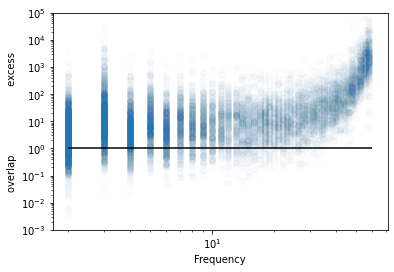

In [14]:
plt.scatter(np.array(freq)*samples.num_samples, [e if o == 1 else o for e,o in zip(overlap, excess)], alpha=0.01)
plt.yscale("log")
plt.xscale("log")

plt.xlabel("Frequency")
plt.ylabel("overlap                      excess")

plt.hlines(1, 2, samples.num_samples)
plt.ylim(0.001, 100000)

In [13]:
len(freq), len(overlap)

(14346, 14346)